[This was one of the more illuminating math videos I've come across](https://www.youtube.com/watch?v=EfZsEFhHcNM) and it did wonders for grounding my intuition on this topic. This notebook will mostly follow along, typing ideas from our other notebooks.

## Overview

Recall the intuition that we arrived at for eigenvectors when we went from following our basis vectors `i` and `j` in a linear transformation to finding the eigenvectors and watching the transformation from the perspective of the stretch/shrink on these vectors.

By orienting yourself to the problem via these vectors, we made it much easier to compute and represent in a new basis. In a way, we can think of these new basis eigen vectors as "the essence" of the transformation. Understanding the multitude of "where does *this* point go?" questions we can ask can all be explained by leveraging the eigenvectors.

To hammer this notion home, I'll share the same video from the Eigenspaces notebook-- [it has a graphic so good that it merits reposting in my own resources](https://youtu.be/8F0gdO643Tc?t=291).

Using this general concept, we want to find a way to learn complex things about a matrix `A` by reformulating the problem into a simpler one based on properties of eigenvectors.

## Ingredients

Before we get into what Singular Value Decomposition *is*, let's first explore the Linear Algebra tricks that make it possible.


### Symmetric, Square Matrix

Say we have a matrix that's square and symmetric across the diag, like the following

```
a  d  e
d  b  f
e  f  c
```

Following along with the example in the video, we'll construct such a matrix, `s`

In [4]:
import numpy as np
import numpy.linalg as LA

s = np.array([[6, -2, -1],
              [-2, 6, -1],
              [-1, -1, 5]])

We'll then use `numpy` to find the eigenvalues and their corresponding eigenvectors

In [7]:
eigvals, eigvecs = LA.eig(s)
eigvals

array([3., 8., 6.])

The vectors have the interesting property of being both linearly independent and orthogonal (having dot product `=0`) to one another

In [28]:
import itertools

for vec_a, vec_b in itertools.combinations(eigvecs, 2):
    # is their dot product basically 0?
    # (accounts for float weirdness)
    print(np.isclose(0, np.dot(vec_a, vec_b)))

True
True
True


Furthermore, these eigenvectors are all **orthonormal**. So not only are they perpendicular, but they're also of unit length.

Thankfully, `numpy` handled this for us, but if it didn't we'd just have to scale each column in `eigvecs` by the magnitude of the column.

#### Diagonalizing It

After we've found our orthonormalized eigenvectors, we want to use them to diagonalize our matrix `s` into its constituent eigenbasis ([as discussed in this notebook](https://napsterinblue.github.io/notes/stats/lin_alg/eigenvectors_and_values/)).

Recall that the form here is `S = P D P^-1`, where `D` is our diagonal matrix and `P` is the mapping from our original space into the eigenbasis, in this case it's our matrix `eigvecs`.

In [31]:
eigvecs

array([[ 0.577,  0.707, -0.408],
       [ 0.577, -0.707, -0.408],
       [ 0.577, -0.   ,  0.816]])

Another interesting/useful property of working with the *isonormal eigenbasis* is that `P^-1` is equivalent to `P^T`

In [30]:
LA.inv(eigvecs)

array([[ 0.577,  0.577,  0.577],
       [ 0.707, -0.707, -0.   ],
       [-0.408, -0.408,  0.816]])

This makes calculation very convenient, as we don't need to deliberately calculate the inverse transformation from our eigenbasis to the original basis.

### Engineering Square Matricies

Nearly all of the data that we encounter can be represented via matricies and most of those matricies will likely be non-square. We can, however, use these rectangular matricies to *create* a square matrix by multiplying by the transpose, and vice-versa.

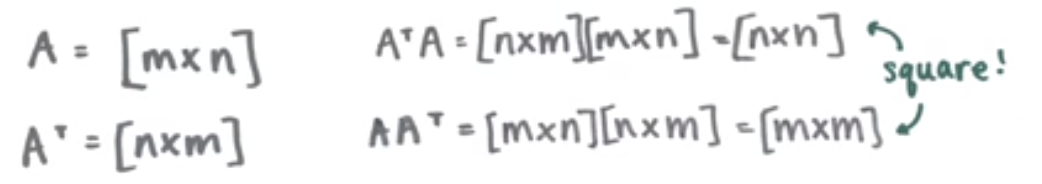

In [38]:
from IPython.display import Image

Image('images/nonsquare_to_square.PNG')

Take the following for example

In [32]:
A = np.array(([4, 11, 14],
              [8, 7, -2]))

In [35]:
AAt = A @ A.T
AAt

array([[333,  81],
       [ 81, 117]])

In [36]:
AtA = A.T @ A
AtA

array([[ 80, 100,  40],
       [100, 170, 140],
       [ 40, 140, 200]])

Furthermore, we can also see that these matricies are symmetric across the diag. This should be intuitive, but the following screengrab from the video spells out the calculation if it's not

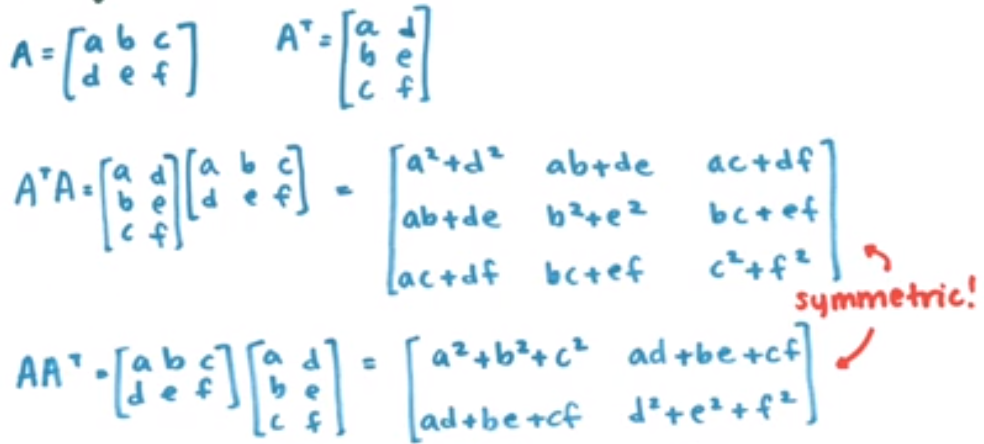

In [40]:
Image('images/symmetric_transposes.PNG')

### Diagonalizing the New Matricies

Moving along, we want to repeat the same orthonormal diagonalization as with our first square, symmetric matrix.

In doing this, we'll finally arrive at some notation that we'll need in performing SVD:

- `D` will be the diagonal matrix of eigenvalues for each `AtA` and `AAt`
- We'll call `V` the matrix that maps `AtA` to `D`
- We'll call `U` the matrix that maps `AAt` to `D`

If you want to follow along in the video, we're at about the 8 minute mark and will be doing these calculations in `numpy`

In [53]:
eigvals_v, V = LA.eig(AtA)
eigvals_v

array([360.,  -0.,  90.])

**Note:** The video stresses many times that our matrix `D` of eigenvalues-- and the corresponding matrix of eigenvectors-- should be ordered in *descending order*. This doesn't come default when using `LA.eig()` (it will when we just use `LA.svd()`). Thus, we will manually reorder them, and construct a diagonal matrix from our 1D vector of eigen values.

In [55]:
eigvals_v = eigvals_v[[0, 2, 1]]
V = V[:, [0, 2, 1]]

In [70]:
D_v = np.diag(eigvals_v)
D_v

array([[360.,   0.,   0.],
       [  0.,  90.,   0.],
       [  0.,   0.,  -0.]])

Again, we can show equality between the inverse and transpose of `V`

In [68]:
np.isclose(LA.inv(V), V.T)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

Doing the same for `AAT`, we have

In [69]:
eigvals_u, U = LA.eig(AAt)
eigvals_u

array([360.,  90.])

In [72]:
D_u = np.diag(eigvals_u)
D_u

array([[360.,   0.],
       [  0.,  90.]])

You might have noted that the eigenvalues of both `D_u` and `D_v` are the exact same. This is no accident and is absolutely something we'll use in the next section.

## Finally Doing SVD